Fetching CSV file from VM...
Data columns before cleaning: ['full_name', 'stargazers_count', 'description', 'created_at', 'updated_at', 'forks_count', 'watchers_count', 'size', 'language', 'has_issues', 'has_projects', 'has_downloads', 'has_wiki', 'has_pages', 'has_discussions', 'archived', 'open_issues_count']
Preprocessing and cleaning data...
Data shape after cleaning: (1000, 17)
Data sample after cleaning:
                                   full_name  stargazers_count  \
0  Stan-Ost/TableViewWithCollapsibleSections                75   
1                    zhouzhuo810/ZzBeeLayout                75   
2       gbyy422990/salience_object_detection                75   
3                         songnick/CircleBar                75   
4                  michalkonturek/LINQ4Obj-C                75   

                                         description            created_at  \
0                                                NaN  2017-05-26T06:15:44Z   
1             A nice Image ViewGr

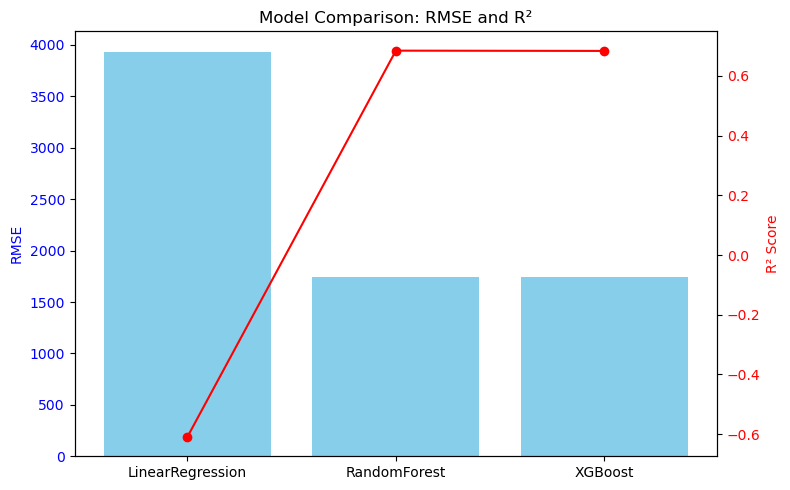


Best model: RandomForest with R²=0.6844
Model saved as best_model.pkl


In [ ]:
import paramiko
import pandas as pd
import io
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import numpy as np
import matplotlib.pyplot as plt

# Try importing XGBoost; if unavailable, skip it
try:
    from xgboost import XGBRegressor
    xgb_available = True
except ImportError:
    print("XGBoost not installed; skipping XGBoost model.")
    xgb_available = False

CLIENT_IP = '130.238.28.11'
ssh_USERNAME = 'ubuntu'
KEY_FILE = '/Users/sparshpaliya/Downloads/PRJ_Group13.pem'
REMOTE_FILE_PATH = '/home/ubuntu/DE2-group-13-project/Development/data/repo_data.csv'

def fetch_csv_via_ssh():
    key = paramiko.RSAKey.from_private_key_file(KEY_FILE)
    ssh_client = paramiko.SSHClient()
    ssh_client.set_missing_host_key_policy(paramiko.AutoAddPolicy())
    ssh_client.connect(hostname=CLIENT_IP, username=ssh_USERNAME, pkey=key)

    sftp = ssh_client.open_sftp()
    with sftp.open(REMOTE_FILE_PATH, 'r') as remote_file:
        csv_data = remote_file.read().decode('utf-8')
    sftp.close()
    ssh_client.close()

    return csv_data

def preprocess_data(df):
    print("Preprocessing and cleaning data...")

    df = df.drop_duplicates()
    df = df.dropna(subset=['stargazers_count', 'created_at', 'updated_at'])

    bool_cols = ['has_issues', 'has_projects', 'has_downloads', 'has_wiki',
                 'has_pages', 'has_discussions', 'archived']
    for col in bool_cols:
        if col in df.columns:
            df[col] = df[col].fillna(False).astype(bool)

    numeric_cols = ['forks_count', 'size', 'open_issues_count']
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            median_val = df[col].median()
            df[col] = df[col].fillna(median_val)

    if 'language' in df.columns:
        df['language'] = df['language'].fillna('Unknown')

    return df

def date_to_days(date_str):
    dt = datetime.strptime(date_str, '%Y-%m-%dT%H:%M:%SZ')
    delta = datetime.now() - dt
    return delta.days

def prepare_features(data):
    target_col = 'stargazers_count'
    # Explicitly exclude watchers_count from features
    leaky_cols = ['watchers_count', 'full_name', 'description']

    X = data.drop(columns=[target_col] + leaky_cols)

    X['days_since_created'] = data['created_at'].apply(date_to_days)
    X['days_since_updated'] = data['updated_at'].apply(date_to_days)
    X = X.drop(columns=['created_at', 'updated_at'])

    X = pd.get_dummies(X, drop_first=True)

    y = data[target_col]

    return X, y

def hyperparameter_tuning_rf(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best RF params: {grid_search.best_params_}")
    return grid_search.best_estimator_

def hyperparameter_tuning_xgb(X_train, y_train):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 1],
    }
    xgb = XGBRegressor(random_state=42, verbosity=0)
    grid_search = GridSearchCV(xgb, param_grid, cv=3, scoring='r2', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(f"Best XGBoost params: {grid_search.best_params_}")
    return grid_search.best_estimator_

def train_and_evaluate_models(X, y):
    y_log = np.log1p(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

    models = {}
    # Linear Regression has no hyperparams to tune
    models["LinearRegression"] = LinearRegression()

    # Tune Random Forest
    print("Hyperparameter tuning Random Forest...")
    rf_best = hyperparameter_tuning_rf(X_train, y_train)
    models["RandomForest"] = rf_best

    if xgb_available:
        print("Hyperparameter tuning XGBoost...")
        xgb_best = hyperparameter_tuning_xgb(X_train, y_train)
        models["XGBoost"] = xgb_best

    results = {}
    for name, model in models.items():
        print(f"\nTraining {name} with best params...")
        model.fit(X_train, y_train)
        y_pred_log = model.predict(X_test)
        y_pred = np.expm1(y_pred_log)
        y_true = np.expm1(y_test)

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        r2 = r2_score(y_true, y_pred)
        print(f"{name} Performance: RMSE={rmse:.4f}, R²={r2:.4f}")

        results[name] = {
            "model": model,
            "rmse": rmse,
            "r2": r2
        }

        if hasattr(model, "feature_importances_"):
            importances = model.feature_importances_
            features = X.columns
            feat_imp = sorted(zip(features, importances), key=lambda x: x[1], reverse=True)
            print(f"Top features for {name}:")
            for feat, imp in feat_imp[:10]:
                print(f"  {feat}: {imp:.4f}")

    # Visualization of model comparison
    visualize_results(results)

    best_name = max(results, key=lambda k: results[k]['r2'])
    best_model = results[best_name]['model']
    print(f"\nBest model: {best_name} with R²={results[best_name]['r2']:.4f}")

    return best_name, best_model

def visualize_results(results):
    import matplotlib.pyplot as plt

    names = list(results.keys())
    rmses = [results[m]['rmse'] for m in names]
    r2s = [results[m]['r2'] for m in names]

    fig, ax1 = plt.subplots(figsize=(8,5))

    ax1.bar(names, rmses, color='skyblue', label='RMSE')
    ax1.set_ylabel('RMSE', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(names, r2s, color='red', marker='o', label='R²')
    ax2.set_ylabel('R² Score', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    plt.title('Model Comparison: RMSE and R²')
    fig.tight_layout()
    plt.show()

def save_model(model, filename):
    with open(filename, 'wb') as f:
        pickle.dump(model, f)
    print(f"Model saved as {filename}")

def main():
    print("Fetching CSV file from VM...")
    csv_content = fetch_csv_via_ssh()
    data = pd.read_csv(io.StringIO(csv_content))
    print("Data columns before cleaning:", data.columns.tolist())

    data = preprocess_data(data)

    print("Data shape after cleaning:", data.shape)
    print("Data sample after cleaning:")
    print(data.head())

    X, y = prepare_features(data)

    best_name, best_model = train_and_evaluate_models(X, y)

    model_filename = f"best_model.pkl"
    save_model(best_model, model_filename)

if __name__ == "__main__":
    main()
